In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [5]:
target_loc = -0.25
target_scale = 0.05

In [6]:
eps = 1e-10

In [7]:
batch_size = 3000

In [8]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [9]:
def make_target(nsamples):    
    target_y = np.random.uniform(low = 0.0, high = 2.0, size = (nsamples, 1))
    target_x = np.random.normal(loc = target_loc, scale = target_scale, size = (nsamples, 1))
    
    target_x = np.multiply(target_x, 1 + (target_y - 1) / 3)
    
    return np.concatenate([target_x, target_y], axis = 1)

In [10]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)
labels_train = np.expand_dims(labels_train, axis = 1)

In [11]:
train_bkg = labels_train == 0
bkg_data_train = data_train[train_bkg.flatten()]
bkg_labels_train = labels_train[train_bkg.flatten()]
bkg_nuisances_train = nuisances_train[train_bkg.flatten()]

In [12]:
train_sig = labels_train == 1
sig_data_train = data_train[train_sig.flatten()]
sig_labels_train = labels_train[train_sig.flatten()]
sig_nuisances_train = nuisances_train[train_sig.flatten()]

In [13]:
def classifier(data_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(data_in, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 2)
        normalized_outputs = layers.softmax(outputs)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, normalized_outputs, these_vars

In [14]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [15]:
def make_EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    # generator output
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    
    # target
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [16]:
def make_plots():
    batch_size_test = 100000
    xrange = [-0.5, 0.0]
    yrange = [0, 2]
    
    target_test = make_target(batch_size_test)
        
    inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size_test))
    bkg_batch_data = bkg_data_train[inds_bkg]
    bkg_batch_labels = bkg_labels_train[inds_bkg]
    bkg_batch_nuisances = bkg_nuisances_train[inds_bkg]

    inds_sig = np.random.choice(len(sig_data_train), int(batch_size_test))
    sig_batch_data = sig_data_train[inds_sig]
    sig_batch_labels = sig_labels_train[inds_sig]
    sig_batch_nuisances = sig_nuisances_train[inds_sig]
    
    class_pred_bkg = sess.run(class_out_single, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, nuisance_in: bkg_batch_nuisances})
    class_pred_sig = sess.run(class_out_single, feed_dict = {data_in: sig_batch_data, labels_in: sig_batch_labels, nuisance_in: sig_batch_nuisances})
        
    f, axarr = plt.subplots(3)
    axarr[0].hexbin(x = target_test[:, 0], y = target_test[:, 1], gridsize = 100, bins = 'log')
    axarr[0].set_xlim(xrange)
    axarr[0].set_ylim(yrange)
    axarr[0].set_title("target")
    
    axarr[1].hexbin(x = class_pred_bkg, y = bkg_batch_nuisances, gridsize = 100, bins = 'log')
    axarr[1].set_xlim(xrange)
    axarr[1].set_ylim(yrange)
    axarr[1].set_title("background")
    
    axarr[2].hexbin(x = class_pred_sig, y = sig_batch_nuisances, gridsize = 100, bins = 'log')
    axarr[2].set_xlim(xrange)
    axarr[2].set_ylim(yrange)
    axarr[2].set_title("signal")
        

In [17]:
def make_plots_marginal():
    batch_size_test = 100000
    xrange = [-0.5, 0.0]
    yrange = [0, 2]
    
    target_test = make_target(batch_size_test)
        
    inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size_test))
    bkg_batch_data = bkg_data_train[inds_bkg]
    bkg_batch_labels = bkg_labels_train[inds_bkg]
    bkg_batch_nuisances = bkg_nuisances_train[inds_bkg]

    inds_sig = np.random.choice(len(sig_data_train), int(batch_size_test))
    sig_batch_data = sig_data_train[inds_sig]
    sig_batch_labels = sig_labels_train[inds_sig]
    sig_batch_nuisances = sig_nuisances_train[inds_sig]
    
    class_pred_bkg = sess.run(class_out_single, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, nuisance_in: bkg_batch_nuisances})
    class_pred_sig = sess.run(class_out_single, feed_dict = {data_in: sig_batch_data, labels_in: sig_batch_labels, nuisance_in: sig_batch_nuisances})

    sns.jointplot(x = target_test[:, 0], y=target_test[:, 1], kind='kde', xlim = xrange, ylim = yrange)
    sns.jointplot(x = class_pred_bkg, y=bkg_batch_nuisances, kind='kde', xlim = xrange, ylim = yrange)
    sns.jointplot(x = class_pred_sig, y=sig_batch_nuisances, kind='kde', xlim = xrange, ylim = yrange)

In [18]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
target_in = tf.placeholder(tf.float32, [None, 2], name = 'target_in')
labels_in = tf.placeholder(tf.float32, [None, 1], name = 'labels_in')
nuisance_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisance_in')

In [19]:
class_out, norm_class_out, gen_vars = classifier(data_in, "gen")

In [20]:
labels_one_hot = tf.squeeze(tf.one_hot(tf.dtypes.cast(labels_in, tf.int32), depth = 2))

In [21]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = norm_class_out)

In [22]:
bkg_truth = tf.where(tf.math.less(labels_in, 1))

In [23]:
class_out_single = tf.expand_dims(class_out[:,1], axis = 1)

In [24]:
class_out_bkg = tf.gather_nd(class_out_single, bkg_truth)
class_out_bkg = tf.expand_dims(class_out_bkg, axis = 1)

In [25]:
nuisance_in_bkg = tf.gather_nd(nuisance_in, bkg_truth)
nuisance_in_bkg = tf.expand_dims(nuisance_in_bkg, axis = 1)

In [26]:
output_dist = tf.concat([class_out_bkg, nuisance_in_bkg], axis = 1)

In [27]:
EM_lossval, EM_vars, EM_dist = make_EM_loss(output_dist, target_in, "EM_loss_obj")

In [28]:
total_loss = classification_loss + EM_dist

In [29]:
train_EM = tf.train.AdamOptimizer(learning_rate = 5e-3, beta1 = 0.0, beta2 = 0.5).minimize(EM_lossval, var_list = EM_vars)

In [30]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(EM_dist, var_list = gen_vars)

In [31]:
train_class_total_loss = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(total_loss, var_list = gen_vars)

In [32]:
train_class = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(classification_loss, var_list = gen_vars)

In [33]:
sess.run(tf.global_variables_initializer())

In [34]:
init_critic = tf.variables_initializer(EM_vars)

In [35]:
sess.run(init_critic)

In [36]:
for i in range(200):
    target = make_target(batch_size)
    inds = np.random.choice(len(bkg_data_train), batch_size)
    data_batch = bkg_data_train[inds]
    labels_batch = bkg_labels_train[inds]
    nuisances_batch = bkg_nuisances_train[inds]
    
    sess.run(train_EM, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                    nuisance_in: nuisances_batch})

    EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                                nuisance_in: nuisances_batch})
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [-0.00511573]
EM_dist = [-0.00943919]
EM_dist = [-0.00741716]
EM_dist = [-0.02248943]
EM_dist = [-0.01996875]
EM_dist = [-0.02264547]
EM_dist = [-0.03289339]
EM_dist = [-0.04041475]
EM_dist = [-0.01671994]
EM_dist = [0.01603353]
EM_dist = [-0.01179504]
EM_dist = [0.02020067]
EM_dist = [0.04005444]
EM_dist = [0.05276775]
EM_dist = [0.04447484]
EM_dist = [0.05415809]
EM_dist = [0.04595196]
EM_dist = [0.05920553]
EM_dist = [0.06394827]
EM_dist = [0.10391581]
EM_dist = [0.06950992]
EM_dist = [0.09314561]
EM_dist = [0.0549801]
EM_dist = [0.12441623]
EM_dist = [0.06735015]
EM_dist = [0.10041046]
EM_dist = [0.08499378]
EM_dist = [0.10263515]
EM_dist = [0.09880352]
EM_dist = [0.10832989]
EM_dist = [0.07718438]
EM_dist = [0.11474061]
EM_dist = [0.09385908]
EM_dist = [0.10926044]
EM_dist = [0.10701215]
EM_dist = [0.12216949]
EM_dist = [0.07874542]
EM_dist = [0.10719061]
EM_dist = [0.08329034]
EM_dist = [0.09920275]
EM_dist = [0.08163226]
EM_dist = [0.11426389]
EM_dist = [0.08504945]
EM

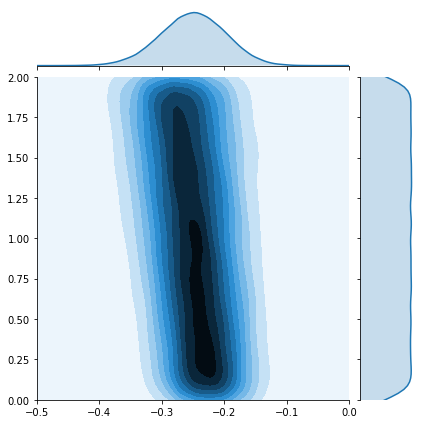

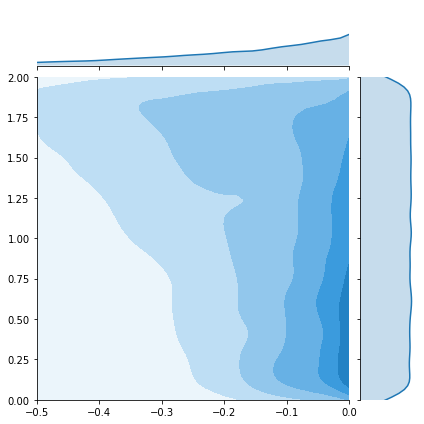

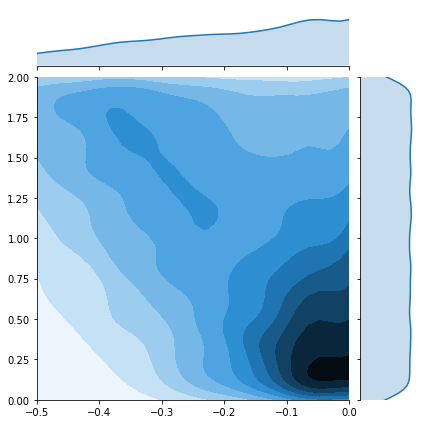

In [42]:
make_plots_marginal()
plt.show()

In [38]:
def perform_training(training_op, epochs, ME_epochs):
    for i in range(0, epochs):
        # prepare noise
        for j in range(ME_epochs):
            target = make_target(batch_size)
            inds = np.random.choice(len(bkg_data_train), batch_size)
            bkg_batch_data = bkg_data_train[inds]
            bkg_batch_labels = bkg_labels_train[inds]
            bkg_batch_nuisances = bkg_nuisances_train[inds]

            sess.run(train_EM, feed_dict = {data_in: bkg_batch_data, target_in: target, labels_in: bkg_batch_labels,
                                           nuisance_in: bkg_batch_nuisances})

        target = make_target(int(batch_size / 2))
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]

        inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size / 2))
        bkg_batch_data = bkg_data_train[inds_bkg]
        bkg_batch_labels = bkg_labels_train[inds_bkg]
        bkg_batch_nuisances = bkg_nuisances_train[inds_bkg]

        inds_sig = np.random.choice(len(sig_data_train), int(batch_size / 2))
        sig_batch_data = sig_data_train[inds_sig]
        sig_batch_labels = sig_labels_train[inds_sig]
        sig_batch_nuisances = sig_nuisances_train[inds_sig]

        data_batch = np.concatenate([sig_batch_data, bkg_batch_data])
        labels_batch = np.concatenate([sig_batch_labels, bkg_batch_labels])
        nuisances_batch = np.concatenate([sig_batch_nuisances, bkg_batch_nuisances])
                    
        sess.run(training_op, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})
        EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})
        critic_loss = sess.run(EM_lossval, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})
        class_lossval = sess.run(classification_loss, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})

        print("W = {}".format(EM_dist_val))
        print("critic loss = {}".format(critic_loss))
        print("class loss = {}".format(class_lossval))

In [170]:
perform_training(train_class_total_loss, epochs = 50, ME_epochs = 300)

W = [0.01141238]
critic loss = -0.00975062232464552
class loss = 0.5844731330871582
W = [0.00496125]
critic loss = -0.0026402128860354424
class loss = 0.5994795560836792
W = [0.00030327]
critic loss = 0.0017341312486678362
class loss = 0.5864571332931519
W = [-0.02070975]
critic loss = 0.022482354193925858
class loss = 0.5970187783241272
W = [-0.01175141]
critic loss = 0.013720822520554066
class loss = 0.5939788222312927
W = [0.01779747]
critic loss = -0.015936927869915962
class loss = 0.5897777676582336
W = [0.02778292]
critic loss = -0.026142077520489693
class loss = 0.5988855957984924
W = [-0.03340411]
critic loss = 0.03553162142634392
class loss = 0.5954754948616028
W = [0.00459886]
critic loss = -0.002334783785045147
class loss = 0.5976170301437378
W = [-0.01260543]
critic loss = 0.014576741494238377
class loss = 0.5984808206558228
W = [0.00433469]
critic loss = -0.002361629158258438
class loss = 0.5996381640434265
W = [-0.03391457]
critic loss = 0.035690054297447205
class loss = 

In [54]:
perform_training(train_class, epochs = 100, ME_epochs = 3)

W = [0.740524]
critic loss = -0.7004272937774658
class loss = 0.5924535989761353
W = [0.741903]
critic loss = -0.6789568662643433
class loss = 0.5899330377578735
W = [0.7136431]
critic loss = -0.693335235118866
class loss = 0.5975931882858276
W = [0.7514902]
critic loss = -0.7078405618667603
class loss = 0.6028761267662048
W = [0.72976136]
critic loss = -0.7079591155052185
class loss = 0.6010083556175232
W = [0.783775]
critic loss = -0.6883407831192017
class loss = 0.5955287218093872
W = [0.77654636]
critic loss = -0.6840565800666809
class loss = 0.5845597982406616
W = [0.7332183]
critic loss = -0.7241467833518982
class loss = 0.5844658017158508
W = [0.7999653]
critic loss = -0.7192981243133545
class loss = 0.595791757106781
W = [0.7631415]
critic loss = -0.7249404788017273
class loss = 0.5872820019721985
W = [0.78414375]
critic loss = -0.7332260012626648
class loss = 0.5879320502281189
W = [0.7211541]
critic loss = -0.7158477306365967
class loss = 0.6000116467475891
W = [0.7901815]
cr

In [129]:
perform_training(train_gen, epochs = 50, ME_epochs = 600)

W = [0.00723767]
critic loss = -0.004893305245786905
class loss = 0.5939866304397583
W = [0.02289891]
critic loss = -0.020109614357352257
class loss = 0.5914429426193237
W = [-0.01040506]
critic loss = 0.014557728543877602
class loss = 0.5950588583946228
W = [0.00352573]
critic loss = -0.0005295283626765013
class loss = 0.6071353554725647
W = [-0.00444913]
critic loss = 0.007093672174960375
class loss = 0.6092406511306763
W = [-0.03821063]
critic loss = 0.04058222100138664
class loss = 0.5993581414222717
W = [0.02276063]
critic loss = -0.020358571782708168
class loss = 0.5916091799736023
W = [0.03695107]
critic loss = -0.034920498728752136
class loss = 0.5998755693435669
W = [0.02502179]
critic loss = -0.023170428350567818
class loss = 0.6025210022926331
W = [-0.00441515]
critic loss = 0.0069176191464066505
class loss = 0.5990334749221802
W = [0.00284243]
critic loss = -0.00010973075404763222
class loss = 0.5882115364074707
W = [0.04406381]
critic loss = -0.04233521595597267
class loss

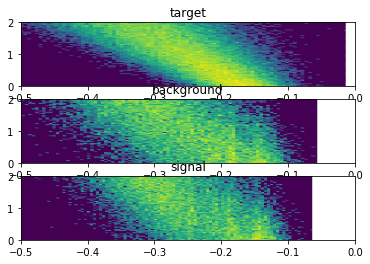

In [171]:
make_plots()
plt.show()
#plt.savefig("shaped_classifier.pdf")

In [107]:
make_plots_marginal()

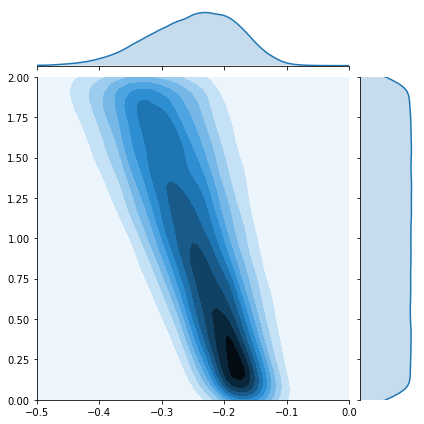

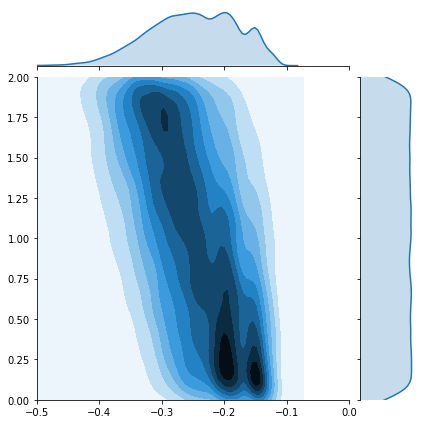

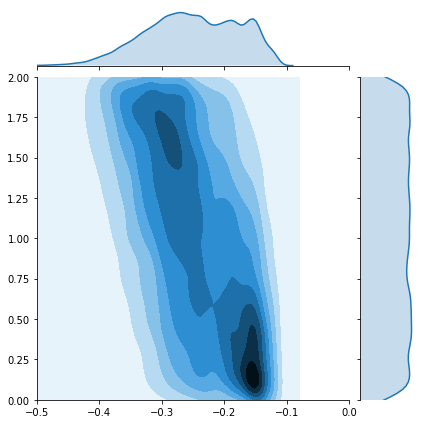

In [108]:
plt.show()

In [156]:
data_test = np.loadtxt("data_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [172]:
pred = sess.run(class_out_single, feed_dict = {data_in: data_test})

In [173]:
from sklearn import metrics

In [174]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred)

In [175]:
LL_pred = np.loadtxt("LL_evaluated.csv")

In [176]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

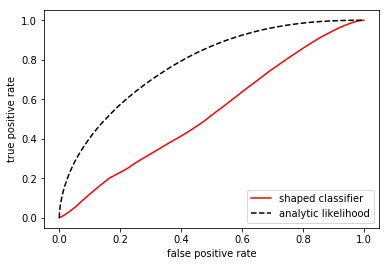

In [177]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'shaped classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()
#plt.savefig("shaped_classifier_ROC.pdf")

In [144]:
metrics.roc_auc_score(labels_test, pred)

0.46547404941485976

In [145]:
metrics.roc_auc_score(labels_test, LL_pred)

0.7783846885778357